In [1]:
import torch
import torchvision
import torchvision.transforms as T
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

from model import Net
from results.HandGestureDataset import HandGestureDataSet as HGD
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from pathlib import Path

ModuleNotFoundError: No module named 'results'

In [ ]:
path = str(Path.home())+'/Documents/data/leapGestRecog/' #
training = HGD(root = path, train = True,
            transform = T.Compose([
                T.ToPILImage(),
                # T.CenterCrop(240),
                T.Resize((64,64)),
                T.ToTensor()
                ]
            ))
validation = HGD(root = path, train= False,
   transform = T.Compose([
                T.ToPILImage(),
                # T.CenterCrop(240),
                T.Resize((64,64)),
                T.ToTensor()
                ]
            ))

batch_size = 32
train_batch = DataLoader(training, batch_size=batch_size, shuffle=True, num_workers= 8)
val_batch = DataLoader(validation, batch_size=batch_size, shuffle=True, num_workers= 8)

In [ ]:
# path = str(Path.home())+'/Documents/data/leapGestRecog/' #
# data = HGD(root = path, train = True,
#             transform = T.Compose([
#                 T.ToPILImage(),
#                 # T.CenterCrop(240),
#                 T.Resize((64,64)),
#                 T.ToTensor()
#                 ]
#             ))
# # print(len(data))
# training, validation = torch.utils.data.random_split(data, [16000,4000])
# batch_size = 32
# train_batch = DataLoader(training, batch_size=batch_size, shuffle=True, num_workers= 8)
# val_batch = DataLoader(validation, batch_size=batch_size, shuffle=True, num_workers= 8)

In [ ]:
def train_model(model, training_data, device, optimizer, epoch):

    """
    This is the main function for training a deep neural network.
    Inputs:
    {
    model: The Neural network
    training_data: Training data with labels
    device: Physical location of where data is stored ("CPU" or "GPU")
    optimizer: Optimizer Function e.g. torch.optim.adam
    scheduler: The type of scheduling for modifying the learning rate
    num_epochs: number of iterations to train on the data
    }

    """

    total_loss = 0
    correct = 0
    model.train() #Set the model to "training" mode and compute gradients
    for batch_idx, (image, label) in enumerate(training_data):
        image, label = image.to(device), label.to(device) # place the input data into gpu ram or cpu ram
        optimizer.zero_grad()
        output = model(image)
        loss = nn.functional.cross_entropy(output, label)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            total_loss += loss.sum().item()
            pred = output.argmax(dim =1 , keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(image), len(training_data.dataset),
                100. * batch_idx / len(training_data), loss.item()))
    print('\nTraining Set: \n\tAverage loss: {:.4f}\n\tAccuracy: {}/{} ({}%)'.format(
        total_loss/len(training_data.dataset),
        correct,
        len(training_data.dataset),
        100*correct/len(training_data.dataset)))
    
    # wandb.watch(model)
    # wandb.log({'Training Loss':total_loss/len(training_data.dataset),'Training Accuracy':correct/len(training_data.dataset)},commit = False)



def validate_model(model, test_data,scheduler, device):

    """
    This is the function to monitor a deep neural network's performance on validation data. Sends images and predictions to wandb
    
    Inputs:
    {
    model: The Neural network
    test_data: test data with labels
    device: Physical location of where data is stored (CPU or GPU)
    }
    
    """
    
    model.eval() #Set the model to "evaluation" mode and NOT compute gradients
    total_loss = 0
    correct = 0 
    with torch.no_grad(): #Prevent pytorch from computing gradients
        for image, label in test_data:
            image, label = image.to(device), label.to(device) # place the input data into gpu ram or cpu ram
            output = model(image)
            total_loss = nn.functional.cross_entropy(output, label, reduction = 'sum').item()
            pred = output.argmax(dim =1 , keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()
    total_loss /= len(test_data.dataset)
    scheduler.step(total_loss)
    print('Test set: \n\tAverage loss: {:.4f}\n\tAccuracy: {}/{} ({}%)\n'.format(
            total_loss,
            correct, 
            len(test_data.dataset),
            100. * correct / len(test_data.dataset)))
    
    
    # wandb.log({'Validation Loss':total_loss,'Validation Accuracy':correct/len(test_data.dataset)},commit = False)
            
            
    #######################################################################################################
    # wandb_iter = iter(test_data)
    # wandb_i,wandb_l = wandb_iter.next()
    # with torch.no_grad():
    #     wandb.log({'Predictions':[wandb.Image(wandb_i[i],caption = f"Label: {int(wandb_l[i])}, Prediction: {int(torch.argmax(model(wandb_i[i].unsqueeze(0).to(device))))}") for i in range(10)] },commit = True)
    #######################################################################################################

# %%

In [ ]:
#################### WANDB Setup ###################
# wandb.init(project = 'ECE6254'
#         ,config = {'learning_rate':0.01, 'batch_size':64}
#             )
# config = wandb.config

# batch_size_train = config.batch_size
# batch_size_test = 1000
# learning_rate = config.learning_rate
####################################################



##### Setup #####
learning_rate = 6e-5
num_epochs = 10 # Number of times to look over the data.
device = "cuda" if torch.cuda.is_available() else "cpu" # Determines if the model will be trained on gpu or cpu
model_ft = Net() # Initialize the model
model_ft = model_ft.to(device) # Send the model to Ram or GPU Ram
optimizer_ft = optim.Adam(model_ft.parameters(), lr=learning_rate, weight_decay = 7e-5) # Initialize optimizer
exp_lr_scheduler = lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft,patience=3,threshold=0.01) #initialize scheduler. Every (1) epoch, reduce the learning rate by a factor of 0.7
#################

print(len(train_batch.dataset))
print("Learning Rate: ",learning_rate,"\nBatch Size: ", batch_size)
print(device)

##### Main Loop for Training ######
for epoch in range(num_epochs):
            train_model(model_ft,
                        train_batch,
                        device, 
                        optimizer_ft, 
                        epoch)
            validate_model(model_ft,
                        val_batch,
                        exp_lr_scheduler,
                        device) 
###################################                         

#################################################
# wandb.finish()
#################################################


12000
Learning Rate:  6e-05 
Batch Size:  32
Train Epoch: 0 [0/12000 (0%)]	Loss: 2.297973
Train Epoch: 0 [3200/12000 (27%)]	Loss: 2.210829
Train Epoch: 0 [6400/12000 (53%)]	Loss: 0.999625
Train Epoch: 0 [9600/12000 (80%)]	Loss: 0.723417

Training Set: 
	Average loss: 0.0424
	Accuracy: 6638/12000 (55.31666666666667%)
Test set: 
	Average loss: 0.0054
	Accuracy: 4239/8000 (52.9875%)

Train Epoch: 1 [0/12000 (0%)]	Loss: 0.285303
Train Epoch: 1 [3200/12000 (27%)]	Loss: 0.301652
Train Epoch: 1 [6400/12000 (53%)]	Loss: 0.306256
Train Epoch: 1 [9600/12000 (80%)]	Loss: 0.153072

Training Set: 
	Average loss: 0.0063
	Accuracy: 11392/12000 (94.93333333333334%)
Test set: 
	Average loss: 0.0073
	Accuracy: 4730/8000 (59.125%)

Train Epoch: 2 [0/12000 (0%)]	Loss: 0.099541
Train Epoch: 2 [3200/12000 (27%)]	Loss: 0.045916
Train Epoch: 2 [6400/12000 (53%)]	Loss: 0.070275
Train Epoch: 2 [9600/12000 (80%)]	Loss: 0.010278

Training Set: 
	Average loss: 0.0018
	Accuracy: 11844/12000 (98.7%)
Test set: 
	Aver

In [ ]:
#################### WANDB Setup ###################
# wandb.init(project = 'ECE6254'
#         ,config = {'learning_rate':0.01, 'batch_size':64}
#             )
# config = wandb.config

# batch_size_train = config.batch_size
# batch_size_test = 1000
# learning_rate = config.learning_rate
####################################################



##### Setup #####

learning_rate = 9e-5
num_epochs = 10 # Number of times to look over the data.
device = "cuda" if torch.cuda.is_available() else "cpu" # Determines if the model will be trained on gpu or cpu
model_ft = Net()
model_ft.load_state_dict(torch.load('autoencoder_dict'),strict = False) # Initialize the model
# model_ft.encoder.requires_grad_(False)
model_ft = model_ft.to(device) # Send the model to Ram or GPU Ram
optimizer_ft = optim.Adam(model_ft.parameters(), lr=learning_rate, weight_decay = 7e-4) # Initialize optimizer
exp_lr_scheduler = lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft,patience=3,threshold=0.01) #initialize scheduler. Every (1) epoch, reduce the learning rate by a factor of 0.7
#################

print(len(train_batch.dataset))
print("Learning Rate: ",learning_rate,"\nBatch Size: ", batch_size)


##### Main Loop for Training ######
for epoch in range(num_epochs):
            train_model(model_ft,
                        train_batch,
                        device, 
                        optimizer_ft, 
                        epoch)
            validate_model(model_ft,
                        val_batch,
                        exp_lr_scheduler,
                        device) 
###################################                         

#################################################
# wandb.finish()
#################################################


12000
Learning Rate:  9e-05 
Batch Size:  32
Train Epoch: 0 [0/12000 (0%)]	Loss: 2.309577
Train Epoch: 0 [3200/12000 (27%)]	Loss: 1.246850
Train Epoch: 0 [6400/12000 (53%)]	Loss: 0.310491
Train Epoch: 0 [9600/12000 (80%)]	Loss: 0.184012

Training Set: 
	Average loss: 0.0280
	Accuracy: 8872/12000 (73.93333333333334%)
Test set: 
	Average loss: 0.0065
	Accuracy: 4601/8000 (57.5125%)

Train Epoch: 1 [0/12000 (0%)]	Loss: 0.131925
Train Epoch: 1 [3200/12000 (27%)]	Loss: 0.128751
Train Epoch: 1 [6400/12000 (53%)]	Loss: 0.055235
Train Epoch: 1 [9600/12000 (80%)]	Loss: 0.022216

Training Set: 
	Average loss: 0.0023
	Accuracy: 11808/12000 (98.4%)
Test set: 
	Average loss: 0.0147
	Accuracy: 4716/8000 (58.95%)

Train Epoch: 2 [0/12000 (0%)]	Loss: 0.042666
Train Epoch: 2 [3200/12000 (27%)]	Loss: 0.009483
Train Epoch: 2 [6400/12000 (53%)]	Loss: 0.045776
Train Epoch: 2 [9600/12000 (80%)]	Loss: 0.004457

Training Set: 
	Average loss: 0.0009
	Accuracy: 11938/12000 (99.48333333333333%)
Test set: 
	Avera

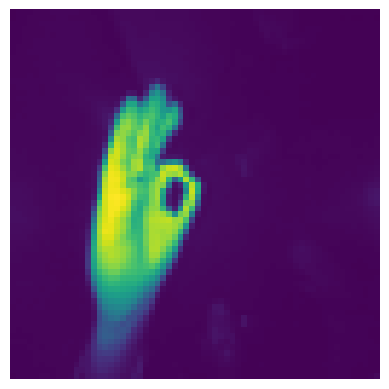

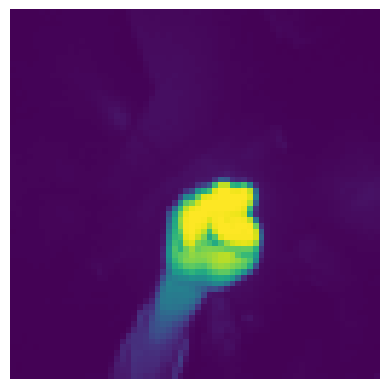

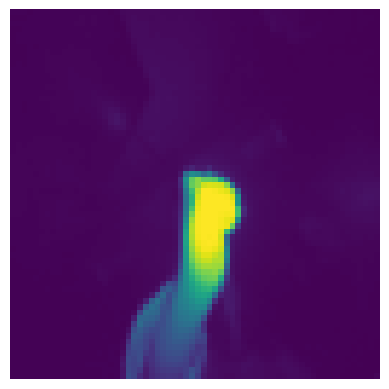

In [ ]:
import matplotlib.pyplot as plt
for i in range(1,4):
    val = iter(val_batch)
    img_val,_ = next(val)
    input_val = img_val.to(device = device)
    img_val = img_val.squeeze()
    model_ft.eval()
    output = model_ft(input_val)
    ae_output = output.squeeze().cpu().detach().numpy()
    # print(output)
    # k = model_ft.forward_encoder(input)
    # print(k.shape)


    plt.imshow(img_val[0])
    plt.axis('off')

    plt.show()



In [ ]:
hello = torch.load('autoencoder_dict')
print(hello['decoder.7.weight'].shape)

torch.Size([1, 512, 5, 5])
